In [1]:
import os
os.chdir("/root/data/DBP_sa_bc/")
from os.path import join as pj
import argparse
import sys
sys.path.append("modules")
import utils
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
# import scipy
import pandas as pd
import re

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--task', type=str, default='ga')
parser.add_argument('--experiment', type=str, default='e1')
parser.add_argument('--model', type=str, default='default')
parser.add_argument('--init_model', type=str, default='sp_latest')
parser.add_argument('--method', type=str, default='DBP_sa_bc')
parser.add_argument('--K', type=int, default='35')
o, _ = parser.parse_known_args()  # for python interactive
# o = parser.parse_args()

In [3]:
# Load break index
K = o.K
break_index_dir = pj("result", o.task, o.experiment, o.model, "predict", o.init_model)

if "DBP_sa_bc" in o.method:
    result_dir = pj("result", "comparison", o.task, o.method, o.experiment, o.init_model)
else:
    result_dir = pj("result", "comparison", o.task, o.method)
cfg_task = re.sub("_atlas|_generalize|_transfer|_ref_.*", "", o.task)
data_config = utils.load_toml("configs/data.toml")[cfg_task]
for k, v in data_config.items():
    vars(o)[k] = v
model_config = utils.load_toml("configs/model.toml")["default"]
if o.model != "default":
    model_config.update(utils.load_toml("configs/model.toml")[o.model])
for k, v in model_config.items():
    vars(o)[k] = v
o.s_joint, o.combs, *_ = utils.gen_all_batch_ids(o.s_joint, o.combs)
output_dir = pj("result", "analysis", o.task, o.method, o.experiment, "fa")


In [4]:
# Load predicted latent variables
o.mods = ["rna"]
o.pred_dir = pj("result", o.task, o.experiment, o.model, "predict", o.init_model)
pred = utils.load_predicted(o, input=False)

Loading predicted variables ...
Loading subset 0: z, joint


100%|██████████| 109/109 [00:00<00:00, 126.12it/s]


Loading subset 0: w, joint


100%|██████████| 109/109 [00:00<00:00, 231.25it/s]


Loading subset 0: EW, joint


100%|██████████| 109/109 [00:00<00:00, 148.63it/s]


Loading subset 0: EA, joint


100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


Loading subset 0: A, joint


100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


Converting to numpy ...
Converting subset 0: s, joint
Converting subset 0: z, joint
Converting subset 0: w, joint
Converting subset 0: EW, joint
Converting subset 0: EA, joint
Converting subset 0: A, joint


In [5]:
# Load genes
genes = pd.read_csv(pj("data", "processed", o.task, "feat", "feat_names_rna.csv"), header=0, index_col=0)
genes = genes["x"]
genes = np.array(genes)

# Load labels
if o.task == "wnn_rna":
    labels1 = []
    labels2 = []
    for raw_data_dir in o.raw_data_dirs:
        label = utils.load_csv(pj(raw_data_dir, "label", "meta.csv"))
        labels1 += utils.transpose_list(label)[10][1:]
        # labels1 += utils.transpose_list(label)[13][1:]
        labels2 += utils.transpose_list(label)[11][1:]
    labels1 = np.array(labels1)
    labels2 = np.array(labels2)
    print(np.unique(labels1))
    print(np.unique(labels2))
elif o.task == "lung_ts":
    labels1 = []
    labels2 = []
    for raw_data_dir in o.raw_data_dirs:
        label = utils.load_csv(pj(raw_data_dir, "label", "meta.csv"))
        labels1 += utils.transpose_list(label)[14][1:]
        labels2 += utils.transpose_list(label)[13][1:]
    labels1 = np.array(labels1)
    labels2 = np.array(labels2)
    print(np.unique(labels1))
    print(np.unique(labels2))
elif o.task == "ga":
    labels1 = []
    # labels2 = []
    for raw_data_dir in o.raw_data_dirs:
        label = utils.load_csv(pj(raw_data_dir, "label", "meta.csv"))
        labels1 += utils.transpose_list(label)[4][1:]
        # labels2 += utils.transpose_list(label)[13][1:]
    labels1 = np.array(labels1)
    # labels2 = np.array(labels2)
    print(np.unique(labels1))
    # print(np.unique(labels2))

# Load index   
index = np.loadtxt(pj(break_index_dir, "break_index.csv"), delimiter=",", dtype=int)

['B.Cell' 'Endocrine.Cell' 'Endothelial.Cell' 'Epithial.Cell'
 'Fibroblasts' 'Macrophages' 'Mast.Cell' 'Parietal.Cell' 'T.Cell']


In [6]:
# break
w = pred["w"]["joint"]
c = pred["z"]["joint"][:, :o.dim_c]*w
s = pred["s"]["joint"]
c_ord = c[:,index]
c_bre = c_ord[:, :K]

g = genes.shape[0]
A = np.array(pred["A"]["joint"][0:g,:]).astype(np.float32)
A_ord = A[:,index]
A_bre = A_ord[:, :K]

In [7]:
# get loadings
F = ["F{}".format(i+1) for i in range(K)]
loadings = pd.DataFrame(A_bre)
loadings.index = genes
loadings.columns = F

### plot all top genes

In [ ]:
# # top or tail genes
# F = ["F{}".format(i+1) for i in range(K)]
# dfc = pd.DataFrame(c_bre.T)
# dfc.index = F
# dfc.columns = labels1

In [ ]:
# plot top genes
for f in F:
    factor = pd.read_table(pj(output_dir, "all_rnks", f, f + ".rnk"), sep='\t',header=None)
    
    labels = factor[0].head(20)
    values = factor[1].head(20)
            
    labels = labels.tolist()
    # color = 'slategray'
    fig, ax = plt.subplots()
    # bars = ax.barh(range(len(labels)), values, color="white", edgecolor="black", linewidth=1,  height=0.8)
    bars = ax.hlines(range(len(labels)),0, values, color='black', linewidth=1)

    for i, value in enumerate(values):
        ax.text(value + 0.02, i, labels[i], ha='left', va='center')
        ax.scatter(value, i, color='black', s=30)
        
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
    ax.set_xlim(0, max(values) * 1.2)
    ax.set_yticks([])
    # ax.set_xticks([])
    ax.set_title(f)
    ax.set_xlabel('Gene Weight') 
    ax.set_ylabel('Top genes')

    # for i, bar in enumerate(bars):
    #     ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2, labels[i], ha='left', va='center')
    #     ax.set_xlim(0, max(values) * 1.2)
    #     ax.set_yticks([])
    #     # ax.set_xticks([])
    #     ax.set_title(f)
    #     ax.set_xlabel('Gene Weight') 
    #     ax.set_ylabel('Top genes')
    plt.savefig(pj(output_dir, "all_rnks", f, f + "_top" + "_genes.png"))

### plot all tail genes

In [ ]:
# plot tail genes
for f in F:
    factor = pd.read_table(pj(output_dir, "all_rnks", f, f + ".rnk"), sep='\t',header=None)
    
    labels = factor[0].tail(20)
    values = abs(factor[1].tail(20))
            
    labels = labels.tolist()
    # color = 'slategray'
    fig, ax = plt.subplots()
    # bars = ax.barh(range(len(labels)), values, color="white", edgecolor="black", linewidth=1,  height=0.8)
    bars = ax.hlines(range(len(labels)),0, values, color='black', linewidth=1)

    for i, value in enumerate(values):
        ax.text(value + 0.02, i, labels[i], ha='left', va='center')
        ax.scatter(value, i, color='black', s=30)
        
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    ax.set_xlim(0, max(values) * 1.2)
    ax.set_yticks([])
    # ax.set_xticks([])
    ax.set_title(f)
    ax.set_xlabel('Gene Weight') 
    ax.set_ylabel('Tail genes')

    # for i, bar in enumerate(bars):
    #     ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2, labels[i], ha='left', va='center')
    #     ax.set_xlim(0, max(values) * 1.2)
    #     ax.set_yticks([])
    #     # ax.set_xticks([])
    #     ax.set_title(f)
    #     ax.set_xlabel('Gene Weight') 
    #     ax.set_ylabel('Top genes')
    plt.savefig(pj(output_dir, "all_rnks", f, f + "_tail" + "_genes.png"))

### plot single top genes

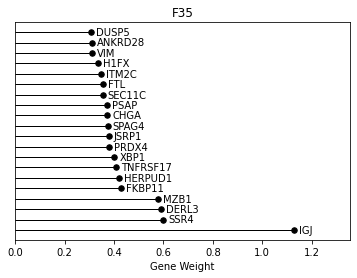

In [8]:
f = "F35"
factor = pd.read_table(pj(output_dir, "all_rnks", f, f + ".rnk"), sep='\t',header=None)

labels = factor[0].head(20)
values = abs(factor[1].head(20))
        
labels = labels.tolist()
# color = 'slategray'
fig, ax = plt.subplots()
# bars = ax.barh(range(len(labels)), values, color="white", edgecolor="black", linewidth=1,  height=0.8)
bars = ax.hlines(range(len(labels)),0, values, color='black', linewidth=1)

for i, value in enumerate(values):
    ax.text(value + 0.02, i, labels[i], ha='left', va='center')
    ax.scatter(value, i, color='black', s=30)

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.set_xlim(0, max(values) * 1.2)
ax.set_yticks([])
# ax.set_xticks([])
ax.set_title(f)
ax.set_xlabel('Gene Weight') 
# ax.set_ylabel('Top genes')

plt.savefig(pj(output_dir, "all_rnks", f, f + "top" + "_genes.png"))
plt.savefig(pj(output_dir, "all_rnks", f, f + "_top" + "_genes.pdf"), format="pdf", bbox_inches="tight")

### plot single tail genes

In [ ]:
f = "F22"
factor = pd.read_table(pj(output_dir, "all_rnks", f, f + ".rnk"), sep='\t',header=None)

labels = factor[0].tail(20)
values = factor[1].tail(20)
        
labels = labels.tolist()
# color = 'slategray'
fig, ax = plt.subplots(figsize=(10, 6))
# bars = ax.barh(range(len(labels)), values, color="white", edgecolor="black", linewidth=1,  height=0.8)
bars = ax.hlines(range(len(labels)),0, values, color='black', linewidth=1)

for i, value in enumerate(values):
    ax.text(value - 0.02, i, labels[i], ha='right', va='center')
    ax.scatter(value, i, color='black', s=30)

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.set_xlim(min(values)-0.2, 0)
ax.set_yticks([])
# ax.set_xticks([])
ax.set_title(f)
# ax.set_xlabel('Gene Weight') 
# ax.set_ylabel('Top genes')

plt.savefig(pj(output_dir, "all_rnks", f, f + "_tail" + "_genes.png"))
plt.savefig(pj(output_dir, "all_rnks", f, f + "_tail" + "_genes.pdf"), format="pdf", bbox_inches="tight")

In [ ]:
# another plot

# data={
#     'x':range(0, len(Factor[1])),
#     'y':Factor[1],
#     'Gene Name':Factor[0]
# }

# df=pd.DataFrame(data)
# # plt.title('Factor 1')
# # plt.xlabel('Genes')
# # plt.ylabel('Gene weight')
# plt.xticks([])
# plt.scatter(df['x'],df['y'],c="gray",s=1**1,zorder=2)

# # selectedGenenames=np.hstack((F1_sort_gene_names_top,F1_sort_gene_names_tail))
# selectedGenenames=Factor[0].tail(20)

# mask=(df['Gene Name'].isin( selectedGenenames ) )
# plt.scatter(df['x'][mask],df['y'][mask],c="black",s=5**2,zorder=3)
# # plt.subplots(figsize=(8,10))
# plt.show()
# # plt.savefig(pj(output_dir, "all_rnks", "F3", "F3.png"))